## КЕЙС-СТАДИ, ЧАСТЬ 2
## Домашняя работа

In [1]:
import numpy as np
import io
import requests
import ssl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as rp

from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report

# следующая строчка подключает сертификат для защищенного соединения
ssl._create_default_https_context = ssl._create_unverified_context
url="http://yustiks.ru/dataset/cardio_train.csv"
data = pd.read_csv(url,sep=";")
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## 1. Написать модель Random Forest на датасет больных сердечными болезнями (можно почистить от выбросов).

In [2]:
output_y = data.iloc[:,:13]
input_x = data

# Таргет значение представим ввиде наименований классов
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
targets=(output_y.iloc[:,:]==1).idxmax(1)
print(targets.value_counts())
Y=le.fit_transform(targets)

gender         45529
cholesterol    18814
gluc            3573
active          1228
smoke            457
cardio           174
alco             127
id                97
ap_hi              1
dtype: int64


In [3]:
# Выделим из датасета тренировочные и тестовые данные. Тренировочные данные будем использовать для обучения модели. 
#Тестовые данные будем использовать для подсчета качества модели.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_x, Y, test_size=0.3)

In [4]:
from sklearn.ensemble import RandomForestClassifier

# создаем модель деревья решений
# выбираем 100 деревьев в качестве параметра
model=RandomForestClassifier(n_estimators=100)

# обучаем модель
model.fit(X_train,y_train)

RandomForestClassifier()

In [5]:
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))
model.score(X_test, y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       330
           1       1.00      1.00      1.00        37
           3       1.00      1.00      1.00        54
           4       1.00      1.00      1.00      5705
           5       1.00      1.00      1.00     13649
           6       1.00      1.00      1.00      1071
           7       1.00      1.00      1.00        30
           8       1.00      1.00      1.00       124

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000



1.0

## 2. Сделать вывод о том, какой атрибут оказывает значительное влияение на наличие или отсутствие болезни.
Основная задача: определить, что влияет на сердечную болезнь больше всего. Например, выдвигая гипотезу о том, что тот кто курит, болеет чаще, мы сравниваем курящих пациентов с некурящими, и определяя насколько статистически значимы выборки, делаем вывод, что одна выборка статистически отличима от другой (или неотличима). Выдвигаем гипотезу на самый важный атрибут, полученный из feature_importance (Random_Forest). И оцениваем гипотезу. И делаем вывод.

No handles with labels found to put in legend.


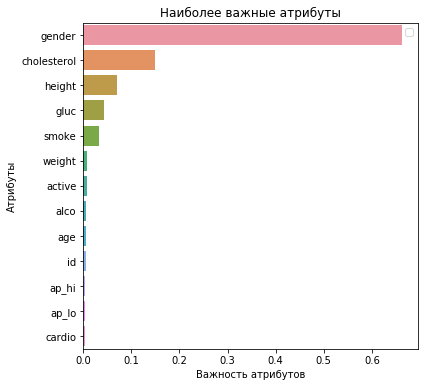

In [6]:
# Наиболее важные атрибуты для модели Random Forest
headers = list(X_train.columns.values)

feature_imp = pd.Series(model.feature_importances_,index=headers).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x=feature_imp, y=feature_imp.index)

plt.xlabel('Важность атрибутов')
plt.ylabel('Атрибуты')
plt.title("Наиболее важные атрибуты")
plt.legend()
plt.show()

Вывод: gender - атрибут данных, оказывающий наиболее значительное влияение на наличие или отсутствие болезни.

### Гипотеза 1: женщины болеют чаще, чем мужчины

In [7]:
female = data[data['gender']==1].cardio
male = data[data['gender']==2].cardio

descriptives, results = rp.ttest(female, male)

print(descriptives)
print('_______________________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  45530.0  0.496727  0.499995  0.002343   0.492135  0.501320
1    cardio  24470.0  0.505231  0.499983  0.003196   0.498966  0.511496
2  combined  70000.0  0.499700  0.500003  0.001890   0.495996  0.503404
_______________________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.0085
1            Degrees of freedom =   69998.0000
2                             t =      -2.1456
3         Two side test p value =       0.0319
4        Difference < 0 p value =       0.0160
5        Difference > 0 p value =       0.9840
6                     Cohen's d =      -0.0170
7                     Hedge's g =      -0.0170
8                 Glass's delta =      -0.0170
9                             r =       0.0081


##### Вывод: гипотеза не верна - женшины болеют реже чем мужчины (поскольку среднее значение для женщин меньше, чем среднее значение для мужчин).



### Гипотеза 2: люди с показателем cholesterol = 2 болеют чаще

In [8]:
chol_2 = data[data['cholesterol']==2].cardio
chol_all = data[data['cholesterol']!=2].cardio

descriptives, results = rp.ttest(chol_2, chol_all)
print(descriptives)
print('_____________________________')
print(results)


   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio   9549.0  0.602157  0.489478  0.005009   0.592339  0.611976
1    cardio  60451.0  0.483516  0.499732  0.002033   0.479532  0.487499
2  combined  70000.0  0.499700  0.500003  0.001890   0.495996  0.503404
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =       0.1186
1            Degrees of freedom =   69998.0000
2                             t =      21.6191
3         Two side test p value =       0.0000
4        Difference < 0 p value =       1.0000
5        Difference > 0 p value =       0.0000
6                     Cohen's d =       0.2381
7                     Hedge's g =       0.2381
8                 Glass's delta =       0.2424
9                             r =       0.0814


##### Вывод: гипотеза верна - люди с показателем cholesterol = 2 болеют чаще, чем остальные (поскольку среднее значение для них больше, чем у остальных).

### Гипотеза 3: люди с показателем height < 165 болеют чаще

In [9]:
height_over165 = data[data['height'] >= 165].cardio
height_all = data[data['height'] < 165].cardio

descriptives, results = rp.ttest(height_over165, height_all)
print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  35574.0  0.492691  0.499954  0.002651   0.487496  0.497887
1    cardio  34426.0  0.506942  0.499959  0.002695   0.501661  0.512224
2  combined  70000.0  0.499700  0.500003  0.001890   0.495996  0.503404
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.0143
1            Degrees of freedom =   69998.0000
2                             t =      -3.7703
3         Two side test p value =       0.0002
4        Difference < 0 p value =       0.0001
5        Difference > 0 p value =       0.9999
6                     Cohen's d =      -0.0285
7                     Hedge's g =      -0.0285
8                 Glass's delta =      -0.0285
9                             r =       0.0142


##### Вывод: гипотеза верна - люди с показателем height < 165  болеют чаще, чем остальные (поскольку среднее значение для них больше, чем у остальных).

### Гипотеза 4: люди с показателем gluc отличным от 1 болеют чаще¶

In [10]:
gluc_1 = data[data['gluc'] == 1].cardio
gluc_all = data[data['gluc'] != 1].cardio

descriptives, results = rp.ttest(gluc_1, gluc_all)
print(descriptives)
print('_____________________________')
print(results)

   Variable        N      Mean        SD        SE  95% Conf.  Interval
0    cardio  59479.0  0.480590  0.499627  0.002049   0.476574  0.484605
1    cardio  10521.0  0.607737  0.488278  0.004760   0.598406  0.617068
2  combined  70000.0  0.499700  0.500003  0.001890   0.495996  0.503404
_____________________________
                Independent t-test     results
0  Difference (cardio - cardio) =      -0.1271
1            Degrees of freedom =   69998.0000
2                             t =     -24.1431
3         Two side test p value =       0.0000
4        Difference < 0 p value =       0.0000
5        Difference > 0 p value =       1.0000
6                     Cohen's d =      -0.2553
7                     Hedge's g =      -0.2553
8                 Glass's delta =      -0.2545
9                             r =       0.0909


##### Вывод: гипотеза верна - люди с показателем gluc отличным от 1 болеют чаще, чем остальные (поскольку среднее значение для них больше, чем у остальных).